## Required Modules

<br>

- matplotlib >= 3.1.1
- mplcursors >= 0.5.1
    - use command to install(in notebook) : **!pip install mplcursors**
- numpy >= 1.21.5
- pandas >= 0.25.1
- sklearn >= 0.21.3

## Import Modules

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors # Use this is for creating a cursor-interactive plot with "%matplotlib notebook"
from sklearn.decomposition import NMF # Use this for training Non-negative Matrix Factorization
from sklearn.utils.extmath import randomized_svd # Use this for training Singular Value Decomposition
from sklearn.manifold import TSNE # Use this for training t-sne manifolding

plt.style.use('ggplot') # You can also use different style

# just for plot checking, use this option
# %matplotlib inline

# for interactive plot
# If you use this option, plot will appear at first-drawn position
%matplotlib notebook

warnings.filterwarnings('ignore')

## Data Loading

<br>

> ### File description : MovieLens-100K
- movies.csv : list of movies (9742 movies)
- ratings.csv : list of ratings given by users (610 users, 100,836 ratings)

In [3]:
dir = './MovieLens100K/'
df_ratings = pd.read_csv(dir + 'ratings.csv', usecols=['userId', 'movieId', 'rating'])
df_movies = pd.read_csv(dir + 'movies.csv', usecols=['movieId', 'title', 'genres']) # for title-matching

## Simple EDA (Exploratory Data Analysis)

<br>

- Before starting, let's perform simple data analysis on the given dataset

In [4]:
# 고유 사용자, 고유 영화 갯수 확인
n_users = len(df_ratings['userId'].unique())
n_movies = len(df_ratings['movieId'].unique())

n_users, n_movies # 610 명의 사용자가 9724개의 영화에 평점을 매김을 확인

(610, 9724)

In [5]:
len(df_movies) # len(df_movies) - n_movies 만큼의 평점이 매겨지지 않은 영화가 존재

9742

In [6]:
# ratings의 기술통계량 확인
df_ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## Generate Utility Matrix $A$

<br>

> ### Problem 1 (2 points)
1. Generate an utility matrix $A$ by using **df_ratings** (store rating values with unique 'movieId' and 'userId')
2. Within a matrix $A$, replace NaN values (unknown ratings) with 0 (zero value)
3. Convert the utility matrix $A$ to **numpy array**

In [7]:
"""
# Utility Matrix의 형태는 (n_movies, n_users)
# 즉 Utility Matrix 의 각 행은 movie, 각 열은 user를 나타냄
"""
# your code here

A = df_ratings.pivot_table(
    values='rating',
    index='movieId',
    columns='userId'
).fillna(0).to_numpy()

# 올바른 형태로 utility matrix가 생성되었는지 확인
print(A.shape)

(9724, 610)


In [9]:
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training SVD Model

<br>

> ### Problem 2 (2 points)
1. Decompose utility matrix $A$ into three matrices $U$, $\sum$, and $V^T$ by training SVD model (you can use  randomized_svd() function provided from scikit-learn)
    - Refer to: https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html

2. After training SVD is completed, perform dot-product of $U$, $\sum$, and $V^T$ to obtain the matrix $A_{approx_{svd}}$ that approximates matrix $A$
    - Note that, **$\sum$ should be a diagonal matrix**, not a vector
    - Before computing $A_{approx_{svd}}$, you will need to transform $\sum$ generated from randomized_svd() to a diagonal matrix

In [11]:
"""
# sklearn에서 제공하는 randomized_svd()를 통해 SVD 모델을 학습하여 U, Sigma, VT를 구함
# k는 분해될 행렬들의 feature/factor 의 크기를 정하는 hyperparameter
# 여러 인자를 조정해서 randomized_svd()를 실행 가능 (자세한 내용은 위의 참고 사이트를 참고)
# 분해된 행렬 U, Sigma, VT의 형태는 (n_movies, k), (k,) (k, n_users)
# 분해된 행렬들을 이용하여 dot-product 연산을 수행하면 원래의 utility matrix와 같은 (n_movies, n_users) 형태의 근사 행렬을 얻을 수 있음
"""

# your code here

k = 200
U, Sigma, VT = randomized_svd(A, n_components = k, n_iter = 'auto')

# 분해된 행렬이 올바른 형태로 생성되었는지 확인
print(U.shape, Sigma.shape, VT.shape)

A_approx_svd = np.dot(np.dot(U, np.diag(Sigma)), VT)

# 근사 행렬이 올바른 형태로 생성되었는지 확인
print(A_approx_svd.shape)

(9724, 200) (200,) (200, 610)
(9724, 610)


In [16]:
pd.DataFrame(A_approx_svd)

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,4.369863,-0.028418,0.028308,-0.723898,2.392201,-0.767365,4.638507,0.737403,0.109692,-1.093836,...,3.596854,0.808704,4.123461,3.951193,4.837215,2.486798,3.154772,2.335773,1.797202,5.090767
1,-0.035517,0.165944,0.046652,-0.682834,0.552239,3.817539,0.468369,2.006760,0.254062,0.651507,...,-0.093165,2.771059,0.097063,3.480376,3.677457,0.004926,0.395203,1.810059,0.205383,-0.014098
2,4.010731,0.092303,0.064154,-0.282133,0.188791,4.877883,-0.470471,0.229130,0.018522,0.437530,...,-0.016440,-0.041376,-0.025834,0.459215,-0.213194,0.063047,0.294684,2.004535,0.270158,0.024232
3,0.061804,-0.061900,0.021160,0.066869,0.037592,2.471325,0.047833,0.045413,0.058134,0.033542,...,0.003114,0.176491,0.026303,0.124345,0.032904,0.004770,0.235569,-0.026220,-0.076638,0.021265
4,0.151504,0.150719,0.089956,0.045812,0.126698,5.138350,0.109869,0.094400,0.007546,-0.224988,...,0.005841,0.616852,-0.057042,1.175043,-0.035875,0.025057,0.039288,-0.160133,0.182657,-0.003387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.017848,0.095370,0.000393,0.001002,0.019897,0.114317,-0.176739,-0.001042,-0.025444,-0.245830,...,0.229816,-0.012765,-0.005428,-0.004824,0.102317,0.007341,-0.062965,0.018945,0.003750,-0.000595
9720,0.015617,0.083449,0.000344,0.000877,0.017410,0.100028,-0.154646,-0.000912,-0.022263,-0.215101,...,0.201089,-0.011169,-0.004750,-0.004221,0.089527,0.006424,-0.055095,0.016577,0.003281,-0.000521
9721,0.015617,0.083449,0.000344,0.000877,0.017410,0.100028,-0.154646,-0.000912,-0.022263,-0.215101,...,0.201089,-0.011169,-0.004750,-0.004221,0.089527,0.006424,-0.055095,0.016577,0.003281,-0.000521
9722,0.015617,0.083449,0.000344,0.000877,0.017410,0.100028,-0.154646,-0.000912,-0.022263,-0.215101,...,0.201089,-0.011169,-0.004750,-0.004221,0.089527,0.006424,-0.055095,0.016577,0.003281,-0.000521


## Training NMF Model

<br>

> ### Problem 3 (2 points)
1. Decompose utility matrix $A$ into two matrices $W$ and $H$ by training NMF model (using NMF()).
    - Refer to: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF

2. After training NMF, perform dot-product of $W$ and $H$ to obtain the matrix $A_{approx_{nmf}}$ that approximates matrix $A$

In [17]:
"""
# sklearn에서 제공하는 NMF()를 통해 NMF 모델을 학습하여 W, H를 구함
# SVD와 마찬가지로, k는 분해될 행렬들의 feature/factor 의 크기를 정하는 hyperparameter
# 여러 인자를 조정해서 NMF() 모델을 생성 (자세한 내용은 위의 참고 사이트를 참고)
# 분해된 행렬 W와 H는 .fit(data)를 실행한 후에 구할수 있으며, W와 H의 형태는 (n_movies, k), (k, n_users)
# 분해된 행렬들을 이용하여 dot-product 연산을 수행하면 원래의 utility matrix와 같은 (n_movies, n_users) 형태의 근사 행렬을 구할 수 있음
"""

# your code here

k = 200
model_nmf = NMF(n_components = k, init='random', random_state=42, max_iter=100, l1_ratio=0.2)
model_nmf.fit(A)
W = model_nmf.transform(A)
H = model_nmf.components_

# 분해된 행렬이 올바른 형태로 생성되었는지 확인
print(W.shape, H.shape)

A_approx_nmf = np.dot(W, H)

# 근사 행렬이 올바른 형태로 생성되었는지 확인
print(A_approx_nmf.shape)

(9724, 200) (200, 610)
(9724, 610)


In [18]:
pd.DataFrame(A_approx_nmf)

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,3.996049,0.480837,0.109989,0.001446,1.192012,0.112153,1.999763,0.998681,0.264671,0.469298,...,4.745750,2.478243,3.982311,2.620831,4.766064,2.499286,4.126589,2.491229,0.770696,4.996823
1,0.000154,0.090068,0.083609,0.000244,0.524692,3.487917,0.703215,1.415068,0.130534,0.000000,...,0.017045,1.740120,0.003388,2.592181,3.376554,0.000000,0.000000,2.026174,0.116272,0.000000
2,3.968787,0.004156,0.062989,0.012566,0.313485,4.963896,0.012829,0.096407,0.050180,0.000000,...,0.002912,0.596193,0.006311,0.592684,0.000000,0.000000,0.000000,1.995239,0.153684,0.000000
3,0.000699,0.002170,0.000000,0.000894,0.104153,2.986455,0.002706,0.041653,0.010058,0.000000,...,0.005029,0.204415,0.000129,0.085203,0.000000,0.000504,0.001252,0.004843,0.012383,0.000943
4,0.004716,0.007832,0.021746,0.000085,0.377900,5.570611,0.001937,0.377921,0.007761,0.000000,...,0.001364,0.919410,0.000736,0.657290,0.000000,0.000000,0.000000,0.000774,0.251947,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.107377,0.000000,0.000176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9720,0.000000,0.093955,0.000000,0.000154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9721,0.000000,0.093955,0.000000,0.000154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9722,0.000000,0.093955,0.000000,0.000154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Compute loss by implementing a custom function

> ### Problem 4 (2 points)
1. Implement **compute_error(actual, prediction)** function that takes matrices 'actual' and 'prediction' as input parameters.
    1. Ignore zero values in the actual maxtrix
    2. Compute SSE and RMSE
    3. Return SSE and RMSE

<br>

2. Implement **compute_error_all(actual, prediction)** function that takes matrices 'actual' and 'prediction' as input parameters.
    1. Do not ignore zero values in the actual matrix (compute all values)
    2. Compute SSE and RMSE
    3. Return SSE and RMSE

In [19]:
"""
# 실제 utility matrix A와 SVD 를 통해 생성된 행렬 A_approx_svd 간의 오차를 계산
# 실제 utility matrix A와 NMF 를 통해 생성된 행렬 A_approx_nmf 간의 오차를 계산
# 오차 값을 계산하기 위해 함수 compute_error(actual, prediction)와 compute_error_all(actual, prediction)를 구현
# 강의시간에 배운 수식을 통해 함수 구현
"""

# your code here

def compute_error(actual, prediction):
    # 매개변수로 입력받은 actual 행렬 안의 0값을 갖는 원소들은 오차 계산에서 제외합니다.
    prediction = prediction[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    sse = np.sum((actual - prediction) ** 2)
    rmse = np.sqrt((sse / len(actual)))
    
    return sse, rmse

def compute_error_all(actual, prediction):
    # actual 행렬 안의 0값을 갖는 원소들도 포함해서 오차를 계산합니다.
    sse = np.sum((actual - prediction) ** 2)
    rmse = np.sqrt((sse / len(actual)))
    
    return sse, rmse

In [20]:
print(f"SVD Error(ignoring zero values): SSE = {compute_error(A, A_approx_svd)[0]}, RMSE = {compute_error(A, A_approx_svd)[1]}")
print(f"NMF Error(ignoring zero values): SSE = {compute_error(A, A_approx_nmf)[0]}, RMSE = {compute_error(A, A_approx_nmf)[1]}")

print('\n')

print(f"SVD Error(including all zero values): SSE = {compute_error_all(A, A_approx_svd)[0]}, RMSE = {compute_error_all(A, A_approx_svd)[1]}")
print(f"NMF Error(including all zero values): SSE = {compute_error_all(A, A_approx_nmf)[0]}, RMSE = {compute_error_all(A, A_approx_nmf)[1]}")

SVD Error(ignoring zero values): SSE = 105987.8189934586, RMSE = 1.025227325328915
NMF Error(ignoring zero values): SSE = 177619.27872888325, RMSE = 1.3272026687005327


SVD Error(including all zero values): SSE = 182411.70814639056, RMSE = 4.331156533961495
NMF Error(including all zero values): SSE = 228721.7888001596, RMSE = 4.849883365081159


## Predict missing (unknown) values in utility matrix $A$ for a specific user


> ### Problem 5 (2 points)

- 실제 평점과 예측 평점을 확인할 수 있는 dataframe 생성을 위해 makePredictions(actual, pred, user) 함수를 정의
- makePredictions() 함수는 user(사용자 번호, user index)를 통해 actual, pred에서 rated movies(seen movies), non-rated movies(unseen movies)를 추출
- 그 다음 앞서 정의했던 df_movies와 추출한 2개의 dataframe을 concat 해줄 것
- column mismatching이 일어날 수 있는데, 우선 dataframe을 모든 column과 concat한 후 불필요한 'movieId' column을 drop 해줄 것
- 이어서 실제로 본 영화 목록을 rated_movies로 정의하고, rating을 기준으로 내림차순 정렬 수행
- 마찬가지로 평점이 부여되지 않은 영화들(평점을 예측하고자하는 영화들)의 목록을 unrated_movies로 정의하고, dataframe의 index를 기준으로 오름차순 정렬 수행

- dataframe의 앞, 뒤를 보는 함수는 .head(), .tail()를 사용할 수 있지만, 중간을 볼 수 있는 함수는 존재하지 않음
- 따라서, 함수 findMiddle(dataframe)을 정의하고, 이 함수는 indexing을 통해 dataframe의 중간 위치를 보여줌
- findMiddle()의 return은 dataframe의 중간 10개 부분

In [21]:
# your code here

def makePredictions(actual, pred, user):
    # rated_movies, unrated_movies 생성을 하기 위한 사전작업 dataframe을 정의할 수 있습니다. (약 4~5줄)
    user -= 1
    rated_items_df = pd.DataFrame(actual).iloc[:, user]
    user_pred_df = pd.DataFrame(pred).iloc[:, user]
    total_df = pd.concat([rated_items_df, user_pred_df, df_movies], axis=1)
    total_df.columns = ['rating', 'prediction', 'movieId', 'title', 'genre']
    total_df = total_df.drop('movieId', axis=1)
    
    
    # 실제로 본 영화 목록 (평점이 부여된 영화 목록)
    rated_movies = total_df.where(total_df['rating']>0)
    rated_movies = rated_movies.dropna()
    rated_movies = rated_movies.sort_values(by='rating', ascending=False)
    
    
    # 예측할 영화 목록 (평점이 부여되지 않은 영화 목록)
    unrated_movies = total_df[total_df['rating'] == 0]
    unrated_movies = unrated_movies.sort_index(ascending=True)
    
    
    return rated_movies, unrated_movies


def findMiddle(dataframe):
    # dataframe의 중간 부분을 반환하는 함수입니다.
    # return은 dataframe의 중간 10개 부분들 입니다. (dataframe 형식)
    if len(dataframe) % 2 == 0:
        return dataframe.iloc[int(len(dataframe) / 2) - 5 : int(len(dataframe) / 2) + 5]
    else:
        return dataframe.iloc[int((len(dataframe) / 2 - 0.5)) - 5 : int(len(dataframe) / 2 + 0.5) + 4]
    

In [22]:
"""
# 임의의 사용자를 1명 선정하고, 앞서 작성한 함수에 svd, nmf의 근사 행렬을 인자로 전달
"""

# your code here

# 임의의 사용자 (정수)를 선택
userNumber = 11

prediction_with_rated_svd, prediction_with_unrated_svd = makePredictions(A, A_approx_svd, userNumber) # 실제 Utility Matrix와 svd를 통해 근사한 행렬 간의 비교
prediction_with_rated_nmf, prediction_with_unrated_nmf = makePredictions(A, A_approx_nmf, userNumber) # 실제 Utility Matrix와 nmf를 통해 근사한 행렬 간의 비교

In [24]:
prediction_with_rated_svd.shape, prediction_with_unrated_svd.shape, prediction_with_rated_nmf.shape, prediction_with_unrated_nmf.shape

((64, 4), (9660, 4), (64, 4), (9660, 4))

In [25]:
prediction_with_rated_svd.head(10)

,rating,prediction,title,genre
5,5.0,2.501560,Heat (1995),Action|Crime|Thriller
307,5.0,3.759683,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
1321,5.0,2.082089,Palmetto (1998),Crime|Drama|Mystery|Romance|Thriller
1290,5.0,3.030953,"Sweet Hereafter, The (1997)",Drama
1275,5.0,0.759245,Alien: Resurrection (1997),Action|Horror|Sci-Fi
1186,5.0,1.717584,"Simple Wish, A (1997)",Children|Fantasy
1083,5.0,1.430583,Scream (1996),Comedy|Horror|Mystery|Thriller
838,5.0,2.318964,Days of Thunder (1990),Action|Drama|Romance
510,5.0,4.275707,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
463,5.0,1.710469,Searching for Bobby Fischer (1993),Drama


In [26]:
prediction_with_rated_nmf.head(10)

,rating,prediction,title,genre
5,5.0,1.382315,Heat (1995),Action|Crime|Thriller
307,5.0,2.876135,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
1321,5.0,0.574519,Palmetto (1998),Crime|Drama|Mystery|Romance|Thriller
1290,5.0,0.820365,"Sweet Hereafter, The (1997)",Drama
1275,5.0,0.325289,Alien: Resurrection (1997),Action|Horror|Sci-Fi
1186,5.0,0.388617,"Simple Wish, A (1997)",Children|Fantasy
1083,5.0,0.493371,Scream (1996),Comedy|Horror|Mystery|Thriller
838,5.0,0.904110,Days of Thunder (1990),Action|Drama|Romance
510,5.0,2.469213,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
463,5.0,0.553724,Searching for Bobby Fischer (1993),Drama


In [27]:
prediction_with_unrated_svd.head(10)

,rating,prediction,title,genre
0,0.0,0.399638,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0.0,0.065416,Jumanji (1995),Adventure|Children|Fantasy
2,0.0,-0.353248,Grumpier Old Men (1995),Comedy|Romance
3,0.0,-0.010748,Waiting to Exhale (1995),Comedy|Drama|Romance
4,0.0,-0.067764,Father of the Bride Part II (1995),Comedy
6,0.0,0.373966,Sabrina (1995),Comedy|Romance
7,0.0,0.015268,Tom and Huck (1995),Adventure|Children
8,0.0,0.134238,Sudden Death (1995),Action
10,0.0,0.484621,"American President, The (1995)",Comedy|Drama|Romance
11,0.0,0.112144,Dracula: Dead and Loving It (1995),Comedy|Horror


In [28]:
prediction_with_unrated_nmf.head(10)

,rating,prediction,title,genre
0,0.0,1.233109,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0.0,0.325042,Jumanji (1995),Adventure|Children|Fantasy
2,0.0,0.349412,Grumpier Old Men (1995),Comedy|Romance
3,0.0,0.006176,Waiting to Exhale (1995),Comedy|Drama|Romance
4,0.0,0.307680,Father of the Bride Part II (1995),Comedy
6,0.0,0.577272,Sabrina (1995),Comedy|Romance
7,0.0,0.004077,Tom and Huck (1995),Adventure|Children
8,0.0,0.156163,Sudden Death (1995),Action
10,0.0,0.676429,"American President, The (1995)",Comedy|Drama|Romance
11,0.0,0.027580,Dracula: Dead and Loving It (1995),Comedy|Horror


In [29]:
prediction_with_unrated_svd.tail(10)

,rating,prediction,title,genre
9714,0.0,0.007710,Dogman (2018),Crime|Drama
9715,0.0,0.006609,Mamma Mia: Here We Go Again! (2018),Comedy|Romance
9716,0.0,0.008811,Tag (2018),Comedy
9717,0.0,0.008811,The Man Who Killed Don Quixote (2018),Adventure|Comedy|Fantasy
9718,0.0,0.007710,Boundaries (2018),Comedy|Drama
9719,0.0,0.008811,Spiral (2018),Documentary
9720,0.0,0.007710,Mission: Impossible - Fallout (2018),Action|Adventure|Thriller
9721,0.0,0.007710,SuperFly (2018),Action|Crime|Thriller
9722,0.0,0.007710,Iron Soldier (2010),Action|Sci-Fi
9723,0.0,-0.016717,BlacKkKlansman (2018),Comedy|Crime|Drama


In [30]:
prediction_with_unrated_nmf.tail(10)

,rating,prediction,title,genre
9714,0.0,0.000000,Dogman (2018),Crime|Drama
9715,0.0,0.000000,Mamma Mia: Here We Go Again! (2018),Comedy|Romance
9716,0.0,0.000000,Tag (2018),Comedy
9717,0.0,0.000000,The Man Who Killed Don Quixote (2018),Adventure|Comedy|Fantasy
9718,0.0,0.000000,Boundaries (2018),Comedy|Drama
9719,0.0,0.000000,Spiral (2018),Documentary
9720,0.0,0.000000,Mission: Impossible - Fallout (2018),Action|Adventure|Thriller
9721,0.0,0.000000,SuperFly (2018),Action|Crime|Thriller
9722,0.0,0.000000,Iron Soldier (2010),Action|Sci-Fi
9723,0.0,0.000687,BlacKkKlansman (2018),Comedy|Crime|Drama


In [31]:
findMiddle(prediction_with_unrated_svd)

,rating,prediction,title,genre
4889,0.0,-0.077714,"Good bye, Lenin! (2003)",Comedy|Drama
4890,0.0,0.000685,Hidalgo (2004),Adventure|Drama
4891,0.0,0.051202,Starsky & Hutch (2004),Action|Comedy|Crime|Thriller
4892,0.0,-0.236343,"Reckoning, The (2004)",Crime|Drama
4893,0.0,0.037274,Persona (1966),Drama
4894,0.0,0.011397,"Passion of Anna, The (Passion, En) (1969)",Drama
4895,0.0,-0.013748,"Corbeau, Le (Raven, The) (1943)",Crime|Drama|Thriller
4896,0.0,0.063319,Pickup on South Street (1953),Film-Noir
4897,0.0,-0.003081,"Damned, The (La Caduta degli dei) (1969)",Drama|War
4898,0.0,0.008139,Just One of the Guys (1985),Comedy


In [32]:
findMiddle(prediction_with_unrated_nmf)

,rating,prediction,title,genre
4889,0.0,0.000000e+00,"Good bye, Lenin! (2003)",Comedy|Drama
4890,0.0,1.401848e-09,Hidalgo (2004),Adventure|Drama
4891,0.0,6.254885e-02,Starsky & Hutch (2004),Action|Comedy|Crime|Thriller
4892,0.0,1.102396e-02,"Reckoning, The (2004)",Crime|Drama
4893,0.0,0.000000e+00,Persona (1966),Drama
4894,0.0,0.000000e+00,"Passion of Anna, The (Passion, En) (1969)",Drama
4895,0.0,0.000000e+00,"Corbeau, Le (Raven, The) (1943)",Crime|Drama|Thriller
4896,0.0,0.000000e+00,Pickup on South Street (1953),Film-Noir
4897,0.0,0.000000e+00,"Damned, The (La Caduta degli dei) (1969)",Drama|War
4898,0.0,3.884335e-09,Just One of the Guys (1985),Comedy


## Visualize movie embeddings using T-SNE


> ### Extra Credit (2 points)

- NMF에서 분해되어 나온 행렬 W는 movie에 대한 잠재 표현(latent representation)을 갖고 있음
    - 마찬가지로, SVD에서 분해되어 나온 행렬 U도 movie에 대한 잠재 표현을 가짐
- 잠재 공간에서 실제 영화들이 NMF를 통해 어떻게 임베딩 되었는지 2차원 상으로 변환해 확인할 수 있으며, 대표적인 방법으로 t-sne을 사용할 수 있음
- 여러 인자를 조정해서 TSNE() 모델을 생성 가능 (자세한 내용은 공식 아래 사이트 참고)
    - t-sne 참고 사이트: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    - t-sne 학습 과정에 시간이 다소 소요될 수 있음
- t-sne에서 fit()된 결과를 W_embedded에 저장
- W_embedded.embedding_ 으로 변환된 임베딩 결과물을 확인

In [33]:
# your code here

model_tsne = TSNE(n_components = 2, init='random')
W_embedded = model_tsne.fit(W)

# 실제 2차원으로 변환되었는지 확인
# 변환된 결과는 (n_movies, 2)의 형태
print(W_embedded.embedding_.shape)

(9724, 2)


In [34]:
pd.DataFrame(W_embedded.embedding_)

,0,1
0,-85.303329,-7.140079
1,-84.848541,3.673107
2,-8.508689,60.872147
3,-3.221533,51.954205
4,-3.089321,-80.152397
...,...,...
9719,50.568882,-26.934010
9720,50.242111,-27.220829
9721,50.242111,-27.220829
9722,50.242111,-27.220829


- Plot하기 위해 각 영화 임베딩과 movie dataframe(df_movies)을 결합
- 하지만 위 EDA에서 알 수 있듯이, movie.csv(df_movies)엔 사용자들이 평점을 매기지 않은 영화들이 존재함
- 따라서, 임베딩과 각 영화의 index를 맞추기 위한 작업이 필요함

- 먼저, numpy array로 변환 안된 (즉 dataframe 형태인) Utility matrix를 load하고, index들을 list로 추출
- df_movies에서 'movieId'가 추출한 list에 있는 경우만을 추출 (그러면 이제 df_movies엔 평점이 매겨진 영화들만이 남게 됨)

- (주의! 이때 reset_index(drop=True) 옵션을 사용해줘야 임베딩과 df_movies를 올바르게 결합할 수 있음)
- (그렇지 않으면 index-mismatching이 발생해 NaN값이 생성됨)

- 추출된 내용을 movie_with_embedding에 대입
- movie_with_embedding의 각 끝 열에 앞서 구한 임베딩을 열로 추가
- embedding은 (n_movies, 2)의 형태이므로, 각 column을 1개씩 'tsne1', 'tsne2'로써 movie_with_embedding의 column으로 추가
- 삽입 시, 형태를 맞추기 위해선 .reshape() method가 필요함

In [35]:
# your code here

# 앞서 정의헀던 Utility Matrix와 동일한 방법으로 A2를 정의 (numpy array로 변환할 필요 없음)
A2 = df_ratings.pivot_table(
    values='rating',
    index='movieId',
    columns='userId'
).fillna(0)

# allList엔 A2의 index 값(즉, movieId)들을 list로 변환한 내용이 들어있음
allList = A2.iloc[:].index.values.tolist()

# movie_with_embedding은 df_movies에서 allList와 일치하는 부분만을 가지게 됨
# movie_with_embedding에 'tsne1', 'tsne2' column을 추가 (추가하는 내용은 각각 임베딩의 첫번째 column, 두번째 column)
movie_with_embedding = df_movies[df_movies['movieId'].isin(allList)].reset_index(drop=True)
movie_with_embedding['tsne1'] = pd.Series(W_embedded.embedding_[:, [0]].reshape(-1))
movie_with_embedding['tsne2'] = pd.Series(W_embedded.embedding_[:, [1]].reshape(-1))

In [38]:
# 최종적으로 Plotting을 위해 생성한 dataframe이 어떤 모습으로 생겼는지 확인
# 이때, dataframe에 NaN값이 있어서는 안됨
movie_with_embedding

,movieId,title,genres,tsne1,tsne2
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,-85.303329,-7.140079
1,2,Jumanji (1995),Adventure|Children|Fantasy,-84.848541,3.673107
2,3,Grumpier Old Men (1995),Comedy|Romance,-8.508689,60.872147
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,-3.221533,51.954205
4,5,Father of the Bride Part II (1995),Comedy,-3.089321,-80.152397
...,...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,50.568882,-26.934010
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,50.242111,-27.220829
9721,193585,Flint (2017),Drama,50.242111,-27.220829
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,50.242111,-27.220829


- tsne1, tsne2를 통해 scatter plot을 그릴 것
- 'mplcursors'를 통해 각 point마다 확인하고 싶은 정보를 labelling 해줄 것
- 이 기능을 사용하게 되면 point마다 text를 plot해줄 필요가 없고, 마우스 커서 클릭으로 point의 정보를 볼 수 있음
- 상단 예시 코드에서 YOUR_ANNOTATION_LIST를 적절히 선택해 각 point마다의 제목 또는 장르를 확인할 수 있음
- 이 함수를 사용하기 위해서는 '%matplotlib notebook' 이 필요함

```python
mplcursors.cursor(multiple = True).connect(
    "add", lambda sel: sel.annotation.set_text(
          YOUR_ANNOTATION_LIST[sel.target.index]
))
```

<IPython.core.display.Javascript object>


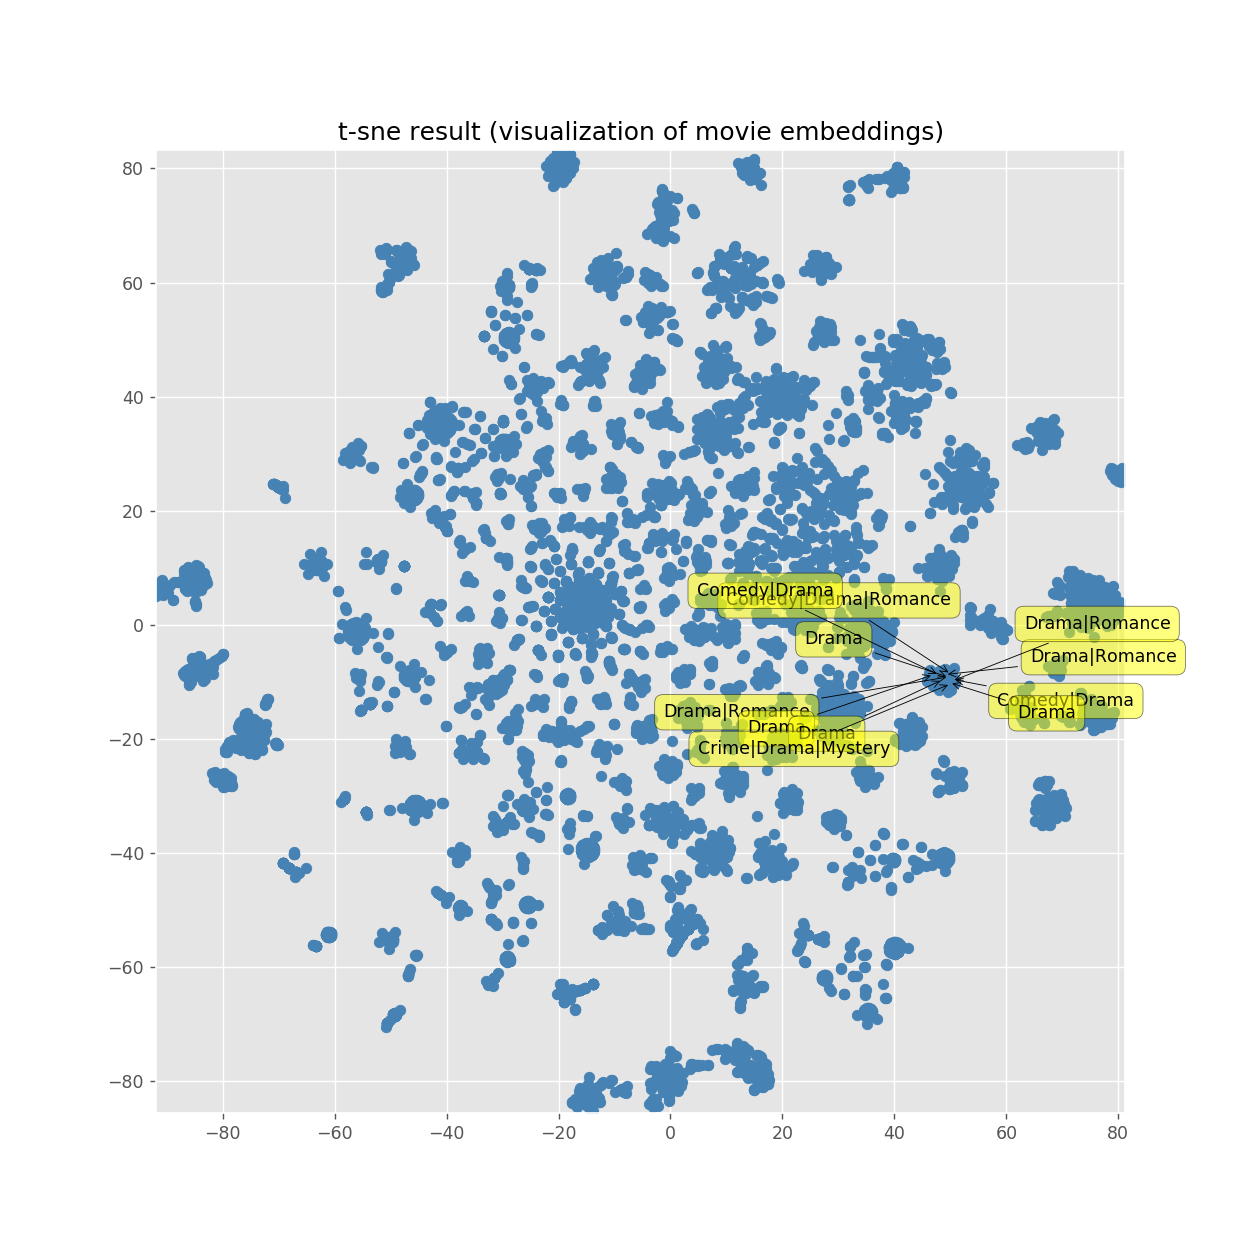

In [39]:
plt.rcParams['figure.figsize'] = [10, 10] # you can change size for your style
plt.xlim(movie_with_embedding['tsne1'].min(), movie_with_embedding['tsne1'].max()) # 축 범위 조정
plt.ylim(movie_with_embedding['tsne2'].min(), movie_with_embedding['tsne2'].max()) # 축 범위 조정

# your code here

# Scatter plot을 그리기
plt.scatter(movie_with_embedding['tsne1'][:], movie_with_embedding['tsne2'][:], c='steelblue')

# 위의 mplcursors 코드를 이용해 각 point마다 labelling을 할 수 있습니다.
# YOUR_ANNOTATION_LIST는 영화 제목이 되어도 좋고, 영화 장르가 되어도 좋습니다.
# (직관성을 위해 '영화장르'로 labelling 하는 것을 추천합니다.)
mplcursors.cursor(multiple = True).connect(
    "add", lambda sel: sel.annotation.set_text(
          movie_with_embedding['genres'][sel.target.index]
))


plt.title('t-sne result (visualization of movie embeddings)')
plt.show()